In [3]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/2022_AN2DL(Private)/ChallengeDL1/

Mounted at /gdrive
/gdrive/My Drive/2022_AN2DL(Private)/ChallengeDL1


#Import libraries

In [4]:
# version of tensorflow needed to be able to use the ConvNeXtLarge
!pip install tensorflow==2.10.0
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 578.0 MB 17 kB/s 
     |████████████████████████████████| 438 kB 49.6 MB/s 
     |████████████████████████████████| 5.9 MB 53.2 MB/s 
     |████████████████████████████████| 1.7 MB 54.8 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully u

#Set seed for reproducibility

In [5]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

#Suppress warnings

In [6]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

#Data loader

In [ ]:
# Load the dataset to be used for classification
!unzip training_dataset_homework1.zip

Archive:  training_dataset_homework1.zip
   creating: training_data_final/Species1/
  inflating: training_data_final/Species1/00000.jpg  
  inflating: training_data_final/Species1/00001.jpg  
  inflating: training_data_final/Species1/00002.jpg  
  inflating: training_data_final/Species1/00003.jpg  
  inflating: training_data_final/Species1/00004.jpg  
  inflating: training_data_final/Species1/00005.jpg  
  inflating: training_data_final/Species1/00006.jpg  
  inflating: training_data_final/Species1/00007.jpg  
  inflating: training_data_final/Species1/00008.jpg  
  inflating: training_data_final/Species1/00009.jpg  
  inflating: training_data_final/Species1/00010.jpg  
  inflating: training_data_final/Species1/00011.jpg  
  inflating: training_data_final/Species1/00012.jpg  
  inflating: training_data_final/Species1/00013.jpg  
  inflating: training_data_final/Species1/00014.jpg  
  inflating: training_data_final/Species1/00015.jpg  
  inflating: training_data_final/Species1/00016.jpg 

In [ ]:
#Install and run splitfolder
#Split folders: 85% of images in train folder, 15% in val folder
!pip install split-folders
import splitfolders
splitfolders.ratio('training_data_final', output='Dataset', seed=seed, ratio=(0.85,0.15))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 3542 files [01:06, 53.53 files/s] 


In [7]:
# Dataset folders 
dataset_dir = 'training_data_final'
training_dir = 'Dataset/train'
validation_dir = 'Dataset/val'

# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator with Data Augmentation for the training data
aug_train_data_gen = ImageDataGenerator(# after many attempts, the most suitable values ​​identified are the following:
                                        rotation_range=30, 
                                        height_shift_range=50, 
                                        width_shift_range=50, 
                                        zoom_range=0.3, 
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect'
                                        ) # rescale value is not necessary with ConvNeXtLarge, normalization is included as part of the model   

val_gen = ImageDataGenerator(#rescale value is not necessary with ConvNeXtLarge, normalization is included as part of the model
                             )                    

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
#generation of training data
train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, 
                                                       class_mode='categorical',
                                                       batch_size=25,
                                                       shuffle=True,
                                                       seed=seed)

#generation of validation data
valid_gen = val_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, 
                                               class_mode='categorical',
                                               batch_size=25,
                                               shuffle=False,
                                               seed=seed)

# Calculate class weights
from collections import Counter
counter = Counter(train_gen.classes)
max_val = float(max(counter.values()))
class_weights = {class_id: max_val/num_images for class_id, num_images in counter.items()}
print(class_weights)

Found 3007 images belonging to 8 classes.
Found 535 images belonging to 8 classes.
{0: 2.8860759493670884, 1: 1.008849557522124, 2: 1.0434782608695652, 3: 1.0506912442396312, 4: 1.0110864745011086, 5: 2.425531914893617, 6: 1.0, 7: 1.0580046403712298}


#Models metadata

In [8]:
#the size of each image in the dataset (96x96)
input_shape = (96, 96, 3)

epochs = 200
patience = 10

#CNN model with transfer learning

785596384/785596384 [==============================] - 3s 0us/step
Model: "convnext_large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 convnext_large_prestem_normali  (None, 224, 224, 3)  0          ['input_1[0][0]']                
 zation (Normalization)                                                                           
                                                                                                  
 convnext_large_stem (Sequentia  (None, 56, 56, 192)  9792       ['convnext_large_prestem_normaliz
 l)               

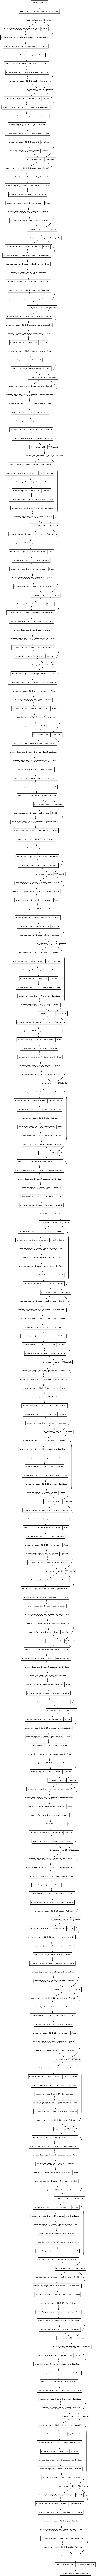

In [7]:
# Apply same preprocessing used to train the supernet 
supernet = tfk.applications.ConvNeXtLarge(
    include_top=False,
    weights="imagenet", 
    input_shape=(224,224,3), #This model takes input images of shape (224, 224, 3)
    pooling="avg", #global average pooling will be applied to the output of the last convolutional layer.
    include_preprocessing=True, 
)

supernet.trainable = False #first training only to our basic model

# Download and plot the model
supernet.summary()
tfk.utils.plot_model(supernet)

In [8]:
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    #resizing of each image from (96,96,3) to (224,224,3)
    x = tfkl.Resizing(224, 224, interpolation="bicubic", name='resizing')(input_layer)

    x = supernet(x)

    #use of a classifier layer composed of 4096 units
    classifier_layer = tfkl.Dense(units=4096, name='Classifier', kernel_initializer=tfk.initializers.HeUniform(seed), activation='relu')(x)

    #output layer classifies the 8 species
    output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy') 

    # Return the model
    return model

In [9]:
# Build model
model = build_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 convnext_large (Functional)  (None, 1536)             196230336 
                                                                 
 Classifier (Dense)          (None, 4096)              6295552   
                                                                 
 output_layer (Dense)        (None, 8)                 32776     
                                                                 
Total params: 202,558,664
Trainable params: 6,328,328
Non-trainable params: 196,230,336
_________________________________________________________________


In [ ]:
# Train the model
model.fit
history = model.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = class_weights, #use of weights identified above
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=patience, restore_best_weights=True)]
).history

model.save("Models/ConvNew3")

Epoch 1/200
121/121 [==============================] - 704s 6s/step - loss: 2.2422 - accuracy: 0.5959 - val_loss: 0.7069 - val_accuracy: 0.7907
Epoch 2/200
121/121 [==============================] - 116s 958ms/step - loss: 0.9974 - accuracy: 0.7213 - val_loss: 0.8693 - val_accuracy: 0.7234
Epoch 3/200
121/121 [==============================] - 116s 956ms/step - loss: 0.9368 - accuracy: 0.7373 - val_loss: 0.6893 - val_accuracy: 0.7645
Epoch 4/200
121/121 [==============================] - 116s 962ms/step - loss: 0.8339 - accuracy: 0.7669 - val_loss: 0.5934 - val_accuracy: 0.8075
Epoch 5/200
121/121 [==============================] - 116s 957ms/step - loss: 0.7532 - accuracy: 0.7855 - val_loss: 0.6744 - val_accuracy: 0.8000
Epoch 6/200
121/121 [==============================] - 116s 956ms/step - loss: 0.7059 - accuracy: 0.7998 - val_loss: 0.6917 - val_accuracy: 0.7888
Epoch 7/200
121/121 [==============================] - 116s 957ms/step - loss: 0.6797 - accuracy: 0.8061 - val_loss: 0.70

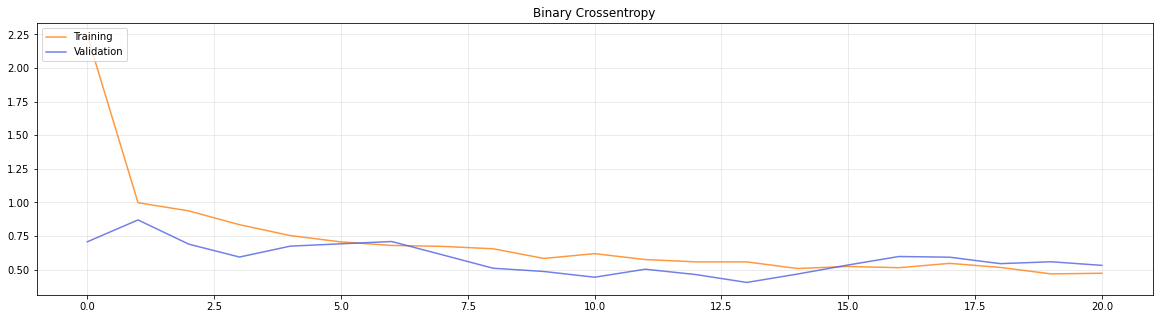

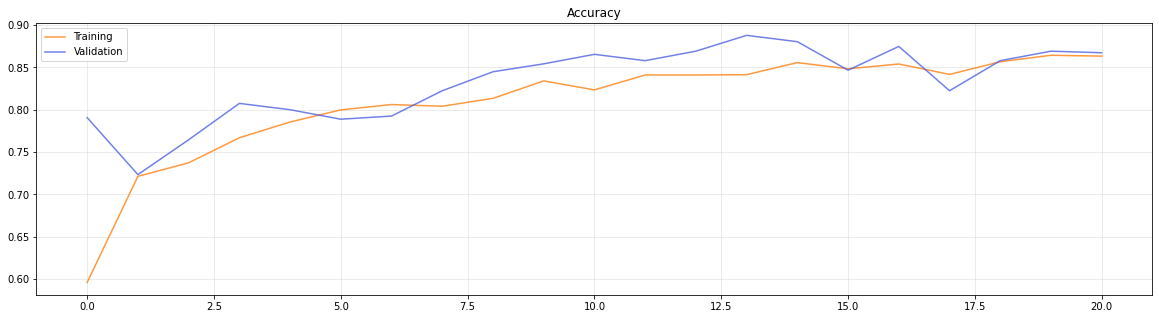

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

#Fine Tuning

In [9]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('Models/ConvNew3')
netname = 'convnext_large'

In [10]:
# Set all layers to True
ft_model.get_layer(netname).trainable = True

# Freeze first 80 layers
for i, layer in enumerate(ft_model.get_layer(netname).layers[:80]):
  layer.trainable=False

ft_model.summary()

# Compile the model with learning rate of 0.0001
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 convnext_large (Functional)  (None, 1536)             196230336 
                                                                 
 Classifier (Dense)          (None, 4096)              6295552   
                                                                 
 output_layer (Dense)        (None, 8)                 32776     
                                                                 
Total params: 202,558,664
Trainable params: 179,856,392
Non-trainable params: 22,702,272
_________________________________________________________________


In [11]:
# Train the model (fine tuning)
ft_model.fit
history = ft_model.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = class_weights,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=patience, restore_best_weights=True)]
).history

ft_model.save('Models/FinalModel')

Epoch 1/200
121/121 [==============================] - 1431s 12s/step - loss: 0.5513 - accuracy: 0.8474 - val_loss: 0.3852 - val_accuracy: 0.8860
Epoch 2/200
121/121 [==============================] - 240s 2s/step - loss: 0.3597 - accuracy: 0.8972 - val_loss: 0.3612 - val_accuracy: 0.8897
Epoch 3/200
121/121 [==============================] - 248s 2s/step - loss: 0.2663 - accuracy: 0.9199 - val_loss: 0.3520 - val_accuracy: 0.8916
Epoch 4/200
121/121 [==============================] - 247s 2s/step - loss: 0.2115 - accuracy: 0.9395 - val_loss: 0.3489 - val_accuracy: 0.9084
Epoch 5/200
121/121 [==============================] - 246s 2s/step - loss: 0.2678 - accuracy: 0.9295 - val_loss: 0.3248 - val_accuracy: 0.9009
Epoch 6/200
121/121 [==============================] - 247s 2s/step - loss: 0.1688 - accuracy: 0.9558 - val_loss: 0.3613 - val_accuracy: 0.9252
Epoch 7/200
121/121 [==============================] - 247s 2s/step - loss: 0.1960 - accuracy: 0.9491 - val_loss: 0.4254 - val_accurac

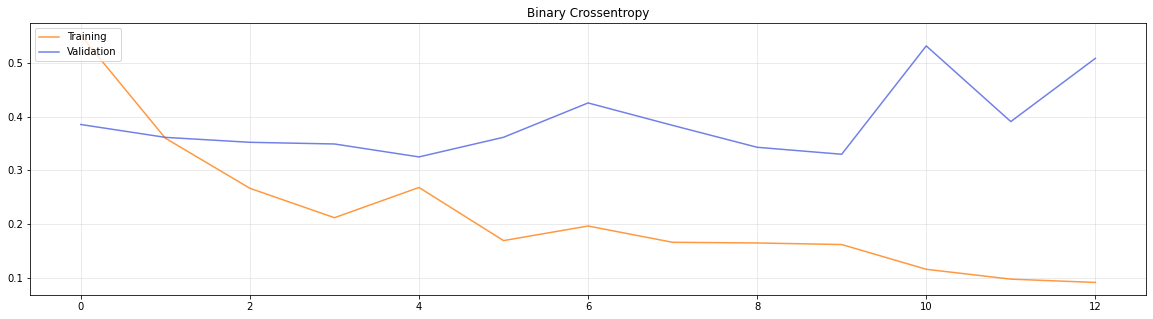

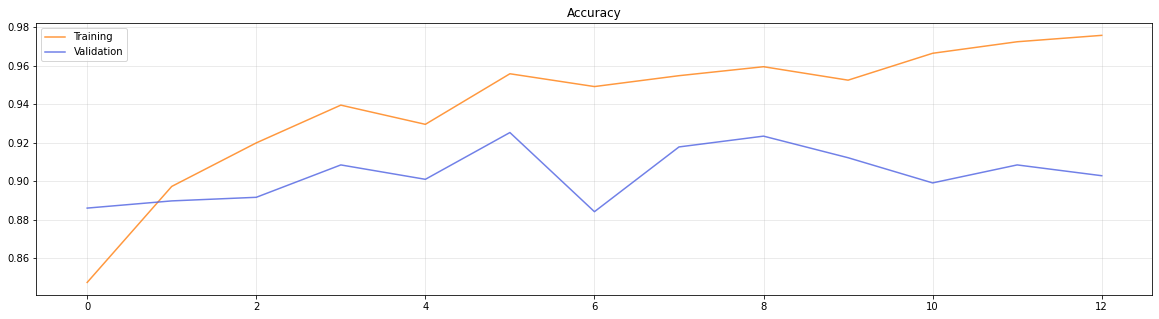

In [12]:
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()